In [1]:
# Reduce to three states, erosion accretion no change 
# split angle into 3 equal

# File Setup

In [ ]:
x_cols = [...]
y_cols = list(df)


def graph(x,y):
    ...
    #save figure

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import stat
import math
import geopandas as gpd
import netCDF4
import datetime
import itertools
import shapely 
from shapely.geometry import LineString, shape
import folium
from colormap import rgb2hex
from folium.plugins import FloatImage
from scipy import interpolate
import alphashape
import descartes
import pyproj
import xarray as xr
from random import sample

transformer = \
    pyproj.Transformer.from_crs(pyproj.CRS("EPSG:32760"),pyproj.CRS("EPSG:4326")) 

In [3]:
import os
import rpy2
os.environ['R_HOME'] = '/lib/R'
%load_ext rpy2.ipython

# Load the Super point data

In [4]:
# # Load the data
# ds_nanumaga = netCDF4.Dataset('SuperPoint_Nanumaga.nc')
# ds_nanumea = netCDF4.Dataset('SuperPoint_Nanumea.nc')

# var_dict = {}

# for ds,atoll in zip([ds_nanumaga,ds_nanumea],['Nanumaga','Nanumea']):
#     # Extract the variables
#     efth = np.array(ds.variables['efth'])
#     time = np.array(ds.variables['time'])
#     dirr = np.array(ds.variables['dir'])
#     freq = np.array(ds.variables['freq'])
#     wdir = np.array(ds.variables['Wdir'])
#     wspd = np.array(ds.variables['Wspeed'])

#     # Adjust time to be datetime (need to confirm the start time)
#     time_start = datetime.datetime(1980,1,1,0,0)
#     time = [(time_start+datetime.timedelta(hours=x)) for x in time]
    
#     var_dict.update({
#         atoll:{
#             'efth':efth,
#             'time':time,
#             'dirr':dirr,
#             'freq':freq,
#             'wdir':wdir,
#             'wspd':wspd
#         }
#     })
    

# Load the shoreline data

In [5]:
# Load the data using geopandas

proxies = [
    r'TOB',
    r'VL',
    r'WM'
]

atolls = [
    'Nanumea',
    'Nanumaga'
]

locations_dict = {
    'Nanumea':[-5.667723, 176.094928],
    'Nanumaga':[-6.287944, 176.321295]
}

combinations = list(itertools.product(atolls,proxies))

# Define the years the shoreline change datafile is for. This is atoll specific
years_dict = {
    'Nanumea':'1971_2020',
    'Nanumaga':'2003_2020'
}

geopandas_dict = {}

for combination in combinations:
    atoll = combination[0]
    proxy = combination[1]
    year = years_dict[combination[0]]
    geopandas_dict.update({
        (atoll,proxy):gpd.read_file('../D9_Tuvalu_shoreline//Shoreline_Definition_Shp/{}/{}_{}_{}.shp'.format(proxy,atoll,proxy,year))
    })



In [6]:
# converting the geopandas dataframes into a useable pd.dataframe

df_xy_dict = {}

for combination in combinations:
    atoll = combination[0]
    proxy = combination[1]
    year = years_dict[combination[0]]
    
    gdf_test = geopandas_dict[atoll,proxy].copy()

    # Correct some typos
    gdf_test.loc[gdf_test.layer=='Nanumea_WM_2015_','layer'] = 'Nanumea_WM_2015'

    gdf_test['layer'] = gdf_test['layer'].fillna(value=1)
    gdf_test['id'] = gdf_test['id'].fillna(value=1)
    gdf_test.dropna(inplace=True)

    years_list = []
    gdf_right_years_dict = {}

    for layer,group in gdf_test.groupby('layer'):
        if (proxy=='VL')&(atoll!='Nanumaga'):
            year = int(layer.split('_')[1])
        else:
            year = int(layer.split('_')[-1])
        years_list.append(year)

        gdf_right_years_dict.update({
            year:group
        })

    gdf_test = pd.concat(gdf_right_years_dict)
    # gdf_test = gdf_test.rename_axis('year')
    gdf_test.reset_index(drop=False,inplace=True)

    # Convert polygons to linestrings if there are any
    if type(gdf_test.loc[0,'geometry'])==shapely.geometry.Polygon:
        gdf_test['geometry'] = [x.boundary for x in gdf_test.geometry]
        
    # Based on the length of the line segments, calculate the number of segments for this islet
    shape = gdf_test.loc[0,'geometry']
    list_of_line_segments = list(shape.coords)
    total_seg_length = 0
    for seg_1,seg_2 in zip(list_of_line_segments[:-1],list_of_line_segments[1:]):
        total_seg_length+=((seg_1[0]-seg_2[0])**2+(seg_1[1]-seg_2[1])**2)**0.5
    line_segment_length_after_interp = 35
    total_number_of_line_segments = int(np.round(total_seg_length/35))
        
    # Interpolate the linestrings so that they are all of the same length (x)
    x = total_number_of_line_segments #number of points to interpolate
    for i in np.arange(0,len(gdf_test),1):
        gdf_test.loc[i,'geometry'] = \
            shapely.geometry.linestring.LineString(
                [gdf_test.loc[i,'geometry'].interpolate((j/x), normalized=True) for j in range(1, x)]
            )

    dict_of_df_xy = {}

    for idx,row in gdf_test.iterrows():
        linestring = row.geometry
        XY_list = []
        
        if type(linestring)==shapely.geometry.linestring.LineString:
            XY_list = XY_list+[(x,y) for x,y in linestring.coords]
        elif type(linestring)==shapely.geometry.multilinestring.MultiLineString:
            XY_list = XY_list+[(x,y) for x,y in linestring[0].coords]
                
        df_xy = pd.DataFrame(XY_list)
        df_xy.columns = ['lon','lat']
        df_xy['id'] = int(row.id)
        df_xy['year'] = int(row.level_0)
#         print(row.id)
        
        dict_of_df_xy.update({
            idx:df_xy
        })

    df_xy = pd.concat(dict_of_df_xy)

    df_xy = df_xy.reset_index(drop=True)

    df_xy[('lat,lon')] = [transformer.transform(x,y) for x,y in zip(df_xy.lon,df_xy.lat)]
    df_xy['lon'] = [x[1] for x in df_xy[('lat,lon')]]
    df_xy['lat'] = [x[0] for x in df_xy[('lat,lon')]]
    
    gdf_test['level_0'] = gdf_test.level_0.astype(int)
    gdf_test['id'] = gdf_test.id.astype(int)
    gdf_test = gdf_test.rename(columns={'level_0':'year'}).drop('level_1',axis=1)
    
    print(np.unique(df_xy.id))
    print(np.unique(gdf_test.id))
    
    df_xy_dict.update({
        (atoll,proxy):{
            'df_xy':df_xy,
            'gdf_test':gdf_test
        }
    })
    

[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[ 1 11]
[ 1 11]
[1]
[1]
[1]
[1]


In [7]:
gdf_test = geopandas_dict[atoll,proxy].copy()

In [8]:
gdf_test

,id,layer,geometry
0,1,Nanumaga_WM_2003,"LINESTRING (424804.160 9303432.237, 424793.511..."
1,1,Nanumaga_WM_2006,"LINESTRING (425283.256 9306121.907, 425313.102..."
2,1,Nanumaga_WM_2008,"LINESTRING (425131.551 9306282.476, 425151.626..."
3,1,Nanumaga_WM_2009,"LINESTRING (424870.654 9306454.737, 424902.057..."
4,1,Nanumaga_WM_2010,"LINESTRING (425369.892 9305874.640, 425370.686..."
5,1,Nanumaga_WM_2011,"LINESTRING (425374.341 9305853.622, 425405.992..."
6,1,Nanumaga_WM_2012,"LINESTRING (425316.298 9306026.362, 425356.911..."
7,1,Nanumaga_WM_2013,"LINESTRING (425420.279 9305734.129, 425417.633..."
8,1,Nanumaga_WM_2014,"LINESTRING (425514.831 9305514.599, 425524.752..."
9,1,Nanumaga_WM_2015,"LINESTRING (425414.359 9305749.971, 425421.895..."


In [9]:
def redistribute_vertices(geom, distance):
    if geom.geom_type == 'LineString':
        num_vert = int(round(geom.length / distance))
        if num_vert == 0:
            num_vert = 1
        return LineString(
            [geom.interpolate(float(n) / num_vert, normalized=True)
             for n in range(num_vert + 1)])
    elif geom.geom_type == 'MultiLineString':
        parts = [redistribute_vertices(part, distance)
                 for part in geom]
        return type(geom)([p for p in parts if not p.is_empty])
    else:
        raise ValueError('unhandled geometry %s', (geom.geom_type,))

## Calculate Islet Area

In [10]:
# Islet area is already calculated, but it doesn't have a good resolution
areas_dict = {}

for key in geopandas_dict.keys():
    print(key)
    df_copy = geopandas_dict[key].copy()
    df_copy['id'] = df_copy['id'].replace([None],1)

    area_per_combo = {}
    
    for index,row in df_copy.iterrows():
        coordinates = []

        if row.geometry!=None:
            if type(row.geometry)==shapely.geometry.linestring.LineString:
                for index_2,point in enumerate(row.geometry.coords):
                    if index_2==0:
                        first_pt = point
                    coordinates.append(point)

                coordinates.append(first_pt)

                poly = shapely.geometry.Polygon(coordinates).area/10**4  
            else:
                poly = row.geometry.area/10**4
            
        else:
            poly = np.nan

        area_per_combo.update({
            (row.id,row.layer.split('-')[-1]):poly
        })
        
    areas_dict.update({
        key:pd.DataFrame.from_dict(area_per_combo,orient='index')
    })
    

('Nanumea', 'TOB')
('Nanumea', 'VL')
('Nanumea', 'WM')
('Nanumaga', 'TOB')
('Nanumaga', 'VL')
('Nanumaga', 'WM')


In [11]:
df_areas = pd.concat(areas_dict)
df_areas = df_areas.reset_index()
df_areas['id'],df_areas['islet_proxy_year'] = zip(*df_areas.level_2)
df_areas['year'] = [x.split('_')[2] if x.split('_')[2].isdigit() else x.split('_')[1] for x in df_areas.islet_proxy_year]
df_areas = df_areas.drop(['islet_proxy_year','level_2'],axis=1)
df_areas.columns = ['islet','proxy','area (ha)','id','year']
# df_areas['islet'] = [x.split('_')[0] for x in df_areas.islet_proxy_year]

df_areas.replace('Nanumaga','Nanumanga',inplace=True)
df_areas.replace('Vegetation','VL',inplace=True)
df_areas.replace('VegetationLine','VL',inplace=True)
df_areas.replace('VegetationLineV1','VL',inplace=True)
df_areas.loc[(df_areas.year=='WM'),'year'] = 2013
df_areas['year'] = df_areas.year.astype(int)

none_indexes = df_areas[~df_areas.id.isin([1,2,3,4,5,6,'1','2','3','4','5','6'])].index
df_areas.loc[none_indexes,'id'] = 1
df_areas['id'] = df_areas.id.astype(int)

df_areas.to_csv('areas.csv',index=False)


In [12]:
df_areas = pd.concat(areas_dict)
df_areas = df_areas.reset_index()
df_areas['id'],df_areas['islet_proxy_year'] = zip(*df_areas.level_2)
df_areas['islet'] = [x.split('_')[0] for x in df_areas.islet_proxy_year]
df_areas['proxy'] = [x.split('_')[1] if not x.split('_')[1].isdigit() else x.split('_')[2] for x in df_areas.islet_proxy_year]
df_areas['year'] = [x.split('_')[2] if x.split('_')[2].isdigit() else x.split('_')[1] for x in df_areas.islet_proxy_year]
df_areas.rename(columns={0:'area (ha)'},inplace=True)
df_areas = df_areas[['id','islet','proxy','year','area (ha)']]
df_areas.replace('Nanumaga','Nanumanga',inplace=True)
df_areas.replace('Vegetation','VL',inplace=True)
df_areas.replace('VegetationLine','VL',inplace=True)
df_areas.replace('VegetationLineV1','VL',inplace=True)
df_areas.loc[(df_areas.year=='WM'),'year'] = 2013
df_areas['year'] = df_areas.year.astype(int)
none_indexes = df_areas[~df_areas.id.isin([1,2,3,4,5,6,'1','2','3','4','5','6'])].index
df_areas.loc[none_indexes,'id'] = 1
df_areas['id'] = df_areas.id.astype(int)

df_areas.to_csv('areas.csv',index=False)

In [13]:
df_areas[(df_areas.islet=='Nanumanga')]

,id,islet,proxy,year,area (ha)
304,1,Nanumanga,TOB,2003,325.007325
305,1,Nanumanga,TOB,2006,322.193925
306,1,Nanumanga,TOB,2019,317.783569
307,1,Nanumanga,TOB,2008,321.934426
308,1,Nanumanga,TOB,2009,319.668520
309,1,Nanumanga,TOB,2010,318.032937
310,1,Nanumanga,TOB,2011,319.845370
311,1,Nanumanga,TOB,2012,321.932275
312,1,Nanumanga,TOB,2013,318.519442
313,1,Nanumanga,TOB,2014,319.594386


# Create features from superpoint data

In [14]:
def efth_stat_calc(df,loc):
    '''
        Function for grouping each dataframe into freq bins and calc stats
    '''
    bin_max = np.max(df.efth)
    bin_mean = np.mean(df.efth)

    bin_stats_dict = {
        loc:{
#             'max':bin_max,
            'mean':bin_mean
        }
    }

    return(bin_stats_dict)

In [15]:
# waves_per_atoll_year_dict = {}

# # Each combination of atoll and proxy combination
# for key,item in df_xy_dict.items():
#     df_xy = item['df_xy']
#     atoll = key[0]

#     # Get all the years
#     years = np.sort(np.unique(df_xy.year))    
#     years_beginning = years[:-1]
#     years_end = years[1:]

#     # Loop over the years, defining the beginning and the end year
#     for year_beginning,year_end in zip(years_beginning,years_end):
            
#         time = var_dict[atoll]['time']
#         freq = var_dict[atoll]['freq']
        
#         beginning = datetime.datetime(year_beginning,1,1,0,0)
#         end = datetime.datetime(year_end,12,31,23,59)
#         beginning_idx = min(range(len(time)), key=lambda i: abs(time[i]-beginning))
#         end_idx = min(range(len(time)), key=lambda i: abs(time[i]-end))

#         #################################################
#         ## get the wave energy for the right time, place
#         #################################################

#         xr_atoll = xr.DataArray(data=var_dict[atoll]['efth'],coords=[var_dict[atoll]['dirr'],var_dict[atoll]['freq'],var_dict[atoll]['time']],
#                                 dims=['dirr','freq','time'])
#         xr_atoll = xr_atoll[:,:,beginning_idx:end_idx]
        
#         # Bin the frequency bins
#         freq_vals = np.unique(freq)
#         freq_vals_bin_edges = freq_vals[::int(round(len(freq_vals)/1.99,0))]
#         freq_vals_bin_edges = list(freq_vals_bin_edges)+[np.max(freq)]
        
#         bin_stats_dict = {}
        
#         for lower,upper in zip(freq_vals_bin_edges[:-1],freq_vals_bin_edges[1:]):
#             beginning_freq_idx = min(range(len(freq)), key=lambda i: abs(freq[i]-lower))
#             end_freq_idx = min(range(len(freq)), key=lambda i: abs(freq[i]-upper))

#             xr_freq_atoll = xr_atoll[:,beginning_freq_idx:end_freq_idx,:].copy()
#             df_xr_atoll = xr_freq_atoll.to_dataframe('efth').reset_index(drop=False)
        
#             # Normalise all values back to 0->360 degress
#             df_xr_atoll.dirr= df_xr_atoll.dirr-np.min(df_xr_atoll.dirr)

#             # Create bins by quadrants
#             df_xr_NE = df_xr_atoll[df_xr_atoll.dirr<=90]
#             df_xr_ES = df_xr_atoll[(df_xr_atoll.dirr>90)&(df_xr_atoll.dirr<=180)]
#             df_xr_SW = df_xr_atoll[(df_xr_atoll.dirr>180)&(df_xr_atoll.dirr<=270)]
#             df_xr_WN = df_xr_atoll[(df_xr_atoll.dirr>270)&(df_xr_atoll.dirr<=360)]

#             # Get stats of efth
#             NE_bin_stats_dict = efth_stat_calc(df_xr_NE,'NE')
#             ES_bin_stats_dict = efth_stat_calc(df_xr_ES,'ES')
#             SW_bin_stats_dict = efth_stat_calc(df_xr_SW,'SW')
#             WN_bin_stats_dict = efth_stat_calc(df_xr_WN,'WN')
            
#             bin_stats_dict.update({
#                 tuple((lower,upper)):{
#                     **NE_bin_stats_dict,
#                     **ES_bin_stats_dict,
#                     **SW_bin_stats_dict,
#                     **WN_bin_stats_dict
#                 }
#             })
        
#         waves_per_atoll_year_dict.update({
#             tuple((key[0],key[1],year_beginning,year_end)):bin_stats_dict
#         })
#         print((key[0],key[1],year_beginning,year_end))


In [16]:
# df_xr_atoll

In [17]:
# df_test = df_xr_atoll[df_xr_atoll.efth>50]
# plt.hist(df_test.efth)

# Function for plotting shoreline

In [18]:

# def shoreline_map(idx,atoll,proxy):
    
#     gdf_test = geopandas_dict[atoll,proxy].copy()
    
#     # Correct some typos
#     gdf_test.loc[gdf_test.layer=='Nanumea_WM_2015_','layer'] = 'Nanumea_WM_2015'
    
#     # Convert polygons to linestrings if there are any
#     if type(gdf_test.loc[0,'geometry'])==shapely.geometry.Polygon:
#         gdf_test['geometry'] = [x.boundary for x in gdf_test.geometry]
    
#     view = 'Satellite'
#     location = locations_dict[atoll]
#     if view == 'Map':
#         map_osm = folium.Map(location=location,zoom_start=11)
#     elif view == 'Satellite':
#         token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
#         tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

#         map_osm = folium.Map(location=location, zoom_start=40, tiles=tileurl, attr='Mapbox')

#     years_list = []
#     for layer,group in gdf_test.groupby('layer'):
#         if (proxy=='VL')&(atoll!='Nanumaga'):
#             year = int(layer.split('_')[1])
#         else:
#             year = int(layer.split('_')[-1])
#         years_list.append(year)

#     gdf_test = gdf_test[gdf_test['id']==idx].reset_index(drop=False)

#     len_years = len(years_list)
#     colours_rgb = matplotlib.pyplot.get_cmap('seismic')(np.arange(0,1+1/len_years,1/(len_years-1)))
#     colour_hex_dict = {i:rgb2hex(int(255*colours_rgb[i][0]),int(255*colours_rgb[i][1]),int(255*(colours_rgb[i][2]))) for i in np.arange(0,len_years,1)}

#     colors_hex_points = [colour_hex_dict[x] for x in np.arange(0,len_years,1)]

#     output_list = []

#     i = 0
#     for layer,group in gdf_test.groupby('layer'):
#         folium.Choropleth(
#             group,
#             line_color=colors_hex_points[i]
#         ).add_to(map_osm)

#         output = plt.Line2D([],[],c=colours_rgb[i])
#         output_list.append(output)

#         i+=1

#     legend = plt.legend(output_list,years_list,title='Year',fontsize=10,ncol=3)
#     plt.setp(legend.get_title(),fontsize=12)
#     plt.axis('off')
#     plt.savefig('legend.png')
#     plt.close()
#     url = (
#         "legend.png"
#     )    
#     FloatImage(url, bottom=55, left=55).add_to(map_osm)
#     print(atoll,proxy)
    
#     return(map_osm)

# Visualise the data together

In [19]:
df_xy[df_xy.id==6]

,lon,lat,id,year,"lat,lon"


In [20]:

# beginning_year = 2019
# end_year = 2020

# beginning = datetime.datetime(beginning_year,1,1,0,0)
# end = datetime.datetime(end_year,12,31,23,59)
# atoll = 'Nanumea'
# proxy = 'WM'
# beginning_idx = min(range(len(time)), key=lambda i: abs(time[i]-beginning))
# end_idx = min(range(len(time)), key=lambda i: abs(time[i]-end))

# #################################################
# ## get the wave energy for the right time, place
# #################################################

# xr_atoll = xr.DataArray(data=var_dict[atoll]['efth'],coords=[var_dict[atoll]['dirr'],var_dict[atoll]['freq'],var_dict[atoll]['time']],
#                         dims=['dirr','freq','time'])
# xr_atoll = xr_atoll[:,:,beginning_idx:end_idx]
# df_xr_atoll = xr_atoll.to_dataframe('efth').reset_index(drop=False)
# df_xr_atoll = df_xr_atoll.sample(10000)


# # wave_energy_subset = {}

# # for time_idx in np.arange(beginning_idx,end_idx,1):
# #     test_freq = efth[:,0,time_idx]
    
# #     wave_energy_subset.update({
# #         time_idx:pd.DataFrame({
# #             'dirr':dirr,
# #             'freq':test_freq
# #         })
# #     })

# # df_wave_energy = pd.concat(wave_energy_subset)

# ####################################################
# ## plotting the atoll
# ####################################################

# df_xy = df_xy_dict[(atoll,proxy)]['df_xy'].copy()

# df_xy_start = df_xy[df_xy.year==beginning_year]
# df_xy_end = df_xy[df_xy.year==end_year]

# ############################################################
# ## Plotting the figure
# ############################################################

# fig = plt.figure(figsize=(10,10))

# rect = [0.1,0.1,0.8,0.8]

# ax1 = fig.add_axes(rect)

# ax1.plot(df_xy_start.lon,df_xy_start.lat,c='r')
# ax1.plot(df_xy_end.lon,df_xy_end.lat,c='k')

# ax2 = fig.add_axes(rect,polar=True,frameon=False)

# ax2.scatter(df_xr_atoll.dirr,df_xr_atoll.efth,alpha=0.5,s=200,c='b')
    
# plt.show()

# Creating Transects

In [21]:

def create_shoreline_df(df_xy):
    # xy = alpha_shape.exterior.coords.xy
    n=2 # length of the shift

    df_shoreline = pd.DataFrame({'x':df_xy.lon[::n],
                                 'x+n':list(df_xy.lon[(n)::n])+[np.nan],
                                 'y':df_xy.lat[::n],
                                 'y+n':list(df_xy.lat[(n)::n])+[np.nan]})

    # Calculate the gradient of the line between the two shoreline points
    df_shoreline['m_shoreline'] = (df_shoreline['y']-df_shoreline['y+n'])/(df_shoreline['x']-df_shoreline['x+n'])
    df_shoreline.dropna(axis=0,inplace=True)
    df_shoreline = df_shoreline[(df_shoreline['x']-df_shoreline['x+n'])!=0]

    # Find the inverse of the gradient (because we are wanting the line that is perpendicular to the shoreline)
    df_shoreline['m_transect'] = -df_shoreline['m_shoreline']**-1

    df_shoreline['x_avg'] = [x/2 for x in (df_shoreline['x']+df_shoreline['x+n'])]
    df_shoreline['y_avg'] = [y/2 for y in (df_shoreline['y']+df_shoreline['y+n'])]

    df_shoreline['c_shoreline'] = df_shoreline['y_avg']-df_shoreline['m_shoreline']*df_shoreline['x_avg']
    df_shoreline['c_transect'] = df_shoreline['y_avg']-df_shoreline['m_transect']*df_shoreline['x_avg']

    # df_shoreline['x_proj'] = df_shoreline['x_avg']+0.01
    # df_shoreline['y_proj'] = df_shoreline['m']*df_shoreline['x_proj']+df_shoreline['c']

    H = 0.001 # length of the line
    delta_y = [abs(H*math.sin(math.atan(m))) for m in df_shoreline['m_transect']]
    delta_x = [abs(H*math.cos(math.atan(m))) for m in df_shoreline['m_transect']]

    # df_shoreline['y_new'] = df_shoreline['y_avg']+delta_y
    # df_shoreline['x_new'] = df_shoreline['x_avg']+delta_x

    df_shoreline['x_new'] = [(x_avg+dx) if y1>y2 else (x_avg-dx) for y1,y2,x_avg,dx in zip(df_shoreline['y'],df_shoreline['y+n'],df_shoreline['x_avg'],delta_x)]
    df_shoreline['y_new'] = [(y_avg+dy) if x1<x2 else (y_avg-dy) for x1,x2,y_avg,dy in zip(df_shoreline['x'],df_shoreline['x+n'],df_shoreline['y_avg'],delta_y)]

    return(df_shoreline)


def calc_shoreline_change(df_shoreline_1,df_shoreline_2,end_year_poly):
    '''
        Function for finding shoreline change between two years
    '''
    ### Now you need to find the distance between the two shorelines using the transects
    shoreline_1_updated_dict = {}

    # loop over each transect
    for idx,row in df_shoreline_1.iterrows():
        
        df_intersection = df_shoreline_2.copy()
        
        df_intersection['x_intersect_location'] = (df_intersection.c_shoreline-row.c_transect)/(row.m_transect-df_intersection.m_shoreline)
        df_intersection['y_intersect_location'] = row['m_transect']*df_intersection['x_intersect_location']+row['c_transect']
        df_intersection['intersect_distance'] = np.sqrt((df_intersection['y_intersect_location']-row['y_avg'])**2+\
        (df_intersection['x_intersect_location']-row['x_avg'])**2)

        # Find which shoreline segments would intersect with the shoreline
        df_intersection = df_intersection[[(x<x_int)&(x_n>x_int)|(x>x_int)&(x_n<x_int)for x,x_int,x_n in zip(df_intersection.x,df_intersection.x_intersect_location,df_intersection['x+n'])]]
        df_intersection = df_intersection[[(y<y_int)&(y_n>y_int)|(y>y_int)&(y_n<y_int) for y,y_int,y_n in zip(df_intersection.y,df_intersection.y_intersect_location,df_intersection['y+n'])]]
        # There may be multiple, so find the closest one (that *should* be the right one)
        
        try:
            df_intersection = df_intersection[(df_intersection['intersect_distance']==np.min(df_intersection['intersect_distance']))]
            intersect_distance = df_intersection.intersect_distance.reset_index(drop=True)[0]
        except:
            intersect_distance = 0
        row['intersect_distance'] = intersect_distance

        shoreline_1_updated_dict.update({
            idx:row
        })

    df_shoreline_1 = pd.DataFrame.from_dict(shoreline_1_updated_dict,orient='index')

    df_shoreline_1['transect_angle'] = \
        np.arctan((df_shoreline_1.y_new-df_shoreline_1.y_avg)/(df_shoreline_1.x_new-df_shoreline_1.x_avg))*180/np.pi

    # Find if there is erosion or accretion
    df_shoreline_1['erosion'] = [shapely.geometry.Point(row.x_avg,row.y_avg).within(end_year_poly) for idx,row in df_shoreline_1.iterrows()]
    
    # If there is erosion, make the value negative
    df_shoreline_1['intersect_distance'] = [dist if eros is False else -dist for dist,eros in zip(df_shoreline_1.intersect_distance,df_shoreline_1.erosion)]
    
    return(df_shoreline_1)


def calc_shoreline_slope_change(df_shoreline_1,df_shoreline_2):
    '''
        Find the rate of change in the shoreline direction
    '''
    
    df_shoreline_1 = pd.concat([df_shoreline_1,df_shoreline_1])
    df_shoreline_2 = pd.concat([df_shoreline_2,df_shoreline_2])

    df_shoreline_1 = df_shoreline_1.reset_index(drop=True)
    df_shoreline_2 = df_shoreline_2.reset_index(drop=True)

    df_shoreline_1_dict = {}

    for (idx_1,row_1),(idx_2,row_2),(idx_3,row_3) in zip(
        df_shoreline_1[2:].iterrows(),
        df_shoreline_1[1:-1].iterrows(),
        df_shoreline_1[:-2].iterrows()):
        
        row_2['avg_slope_change'] = np.mean([
            (180*np.arctan((row_1.m_shoreline-row_2.m_shoreline)/(1+row_1.m_shoreline*row_2.m_shoreline))/np.pi),
            (180*np.arctan((row_2.m_shoreline-row_3.m_shoreline)/(1+row_2.m_shoreline*row_3.m_shoreline))/np.pi)
        ])

        df_shoreline_1_dict.update({
            idx_2:row_2
        })

    # only look at points where there is a significant change
    df_shoreline_1 = pd.DataFrame.from_dict(df_shoreline_1_dict,orient='index')
    
    # Drop the duplicates
    df_shoreline_1 = df_shoreline_1.drop_duplicates()
    df_shoreline_1.reset_index(drop=True,inplace=True)
    
    #### Now also add in the angle (degrees) that the shoreline is facing
    # Quadrant 1
    df_shoreline_1.loc[(df_shoreline_1.x_new>df_shoreline_1.x_avg)&(df_shoreline_1.y_new>df_shoreline_1.y_avg),'shoreline_direction']=\
        [180*math.atan(np.abs(x_new-x_avg)/np.abs(y_new-y_avg))/np.pi for y_new,y_avg,x_new,x_avg in zip(
                df_shoreline_1.y_new,
                df_shoreline_1.y_avg,
                df_shoreline_1.x_new,
                df_shoreline_1.x_avg
                ) if (x_new>x_avg)&(y_new>y_avg)]

    # Quadrant 2
    df_shoreline_1.loc[(df_shoreline_1.x_new>df_shoreline_1.x_avg)&(df_shoreline_1.y_new<df_shoreline_1.y_avg),'shoreline_direction']=\
        [90+180*math.atan(np.abs(y_new-y_avg)/np.abs(x_new-x_avg))/np.pi for y_new,y_avg,x_new,x_avg in zip(
                df_shoreline_1.y_new,
                df_shoreline_1.y_avg,
                df_shoreline_1.x_new,
                df_shoreline_1.x_avg
                ) if (x_new>x_avg)&(y_new<y_avg)]

    # Quadrant 3
    df_shoreline_1.loc[(df_shoreline_1.x_new<df_shoreline_1.x_avg)&(df_shoreline_1.y_new<df_shoreline_1.y_avg),'shoreline_direction']=\
        [180+180*math.atan(np.abs(x_new-x_avg)/np.abs(y_new-y_avg))/np.pi for y_new,y_avg,x_new,x_avg in zip(
                df_shoreline_1.y_new,
                df_shoreline_1.y_avg,
                df_shoreline_1.x_new,
                df_shoreline_1.x_avg
                ) if (x_new<x_avg)&(y_new<y_avg)]

    # Quadrant 4
    df_shoreline_1.loc[(df_shoreline_1.x_new<df_shoreline_1.x_avg)&(df_shoreline_1.y_new>df_shoreline_1.y_avg),'shoreline_direction']=\
        [270+180*math.atan(np.abs(y_new-y_avg)/np.abs(x_new-x_avg))/np.pi for y_new,y_avg,x_new,x_avg in zip(
                df_shoreline_1.y_new,
                df_shoreline_1.y_avg,
                df_shoreline_1.x_new,
                df_shoreline_1.x_avg
                ) if (x_new<x_avg)&(y_new>y_avg)]

    return(df_shoreline_1)

In [22]:
# For each year, proxy and islet combination, find the shoreline change
shorelines_dict = {}

# Each combination of atoll and proxy combination
for key,item in df_xy_dict.items():
    df_xy = item['df_xy']
    gdf_xy = item['gdf_test']
    
    # Now get all the ids for this atoll
    ids = np.unique(df_xy.id)
    
    for ID in ids:
        df_xy_islet = df_xy[df_xy.id==ID]
        gdf_xy_islet = gdf_xy[gdf_xy.id==ID]
            
        # Get all the years
        years = np.sort(np.unique(df_xy_islet.year))
        years_beginning = years[:-1]
        years_end = years[1:]
        
        # Loop over the years, defining the beginning and the end year
        for year_beginning,year_end in zip(years_beginning,years_end):
            
            df_xy_islet_beginning = df_xy_islet[(df_xy_islet.year==year_beginning)]
            df_xy_islet_end = df_xy_islet[(df_xy_islet.year==year_end)]
            
            end_year_linestring = gdf_xy_islet[(gdf_xy_islet.year==year_end)].reset_index().loc[0,'geometry']
            end_year_poly = shapely.ops.transform(lambda x, y: (y, x),
                      shapely.geometry.Polygon([transformer.transform(x,y) for x,y in end_year_linestring.coords])
                     )
            
            
            df_shoreline_1 = create_shoreline_df(df_xy_islet_beginning).reset_index(drop=True)
            df_shoreline_2 = create_shoreline_df(df_xy_islet_end).reset_index(drop=True)

            df_shoreline_1 = calc_shoreline_change(df_shoreline_1,df_shoreline_2,end_year_poly)

            df_shoreline_1 = calc_shoreline_slope_change(df_shoreline_1,df_shoreline_2)
            
            shorelines_dict.update({
                (key[0],key[1],ID,year_beginning,year_end):{
                    'shoreline_1':df_shoreline_1,
                    'shoreline_2':df_shoreline_2
                }
            })
            print((key[0],key[1],ID,year_beginning,year_end))
            
            

('Nanumea', 'TOB', 1, 1971, 1984)
('Nanumea', 'TOB', 1, 1984, 2003)
('Nanumea', 'TOB', 1, 2003, 2005)
('Nanumea', 'TOB', 1, 2005, 2007)
('Nanumea', 'TOB', 1, 2007, 2009)
('Nanumea', 'TOB', 1, 2009, 2010)
('Nanumea', 'TOB', 1, 2010, 2011)
('Nanumea', 'TOB', 1, 2011, 2012)
('Nanumea', 'TOB', 1, 2012, 2013)
('Nanumea', 'TOB', 1, 2013, 2014)
('Nanumea', 'TOB', 1, 2014, 2015)
('Nanumea', 'TOB', 1, 2015, 2016)
('Nanumea', 'TOB', 1, 2016, 2017)
('Nanumea', 'TOB', 1, 2017, 2018)
('Nanumea', 'TOB', 1, 2018, 2019)
('Nanumea', 'TOB', 1, 2019, 2020)
('Nanumea', 'TOB', 2, 1971, 1984)
('Nanumea', 'TOB', 2, 1984, 2003)
('Nanumea', 'TOB', 2, 2003, 2005)
('Nanumea', 'TOB', 2, 2005, 2007)
('Nanumea', 'TOB', 2, 2007, 2009)
('Nanumea', 'TOB', 2, 2009, 2010)
('Nanumea', 'TOB', 2, 2010, 2011)
('Nanumea', 'TOB', 2, 2011, 2012)
('Nanumea', 'TOB', 2, 2012, 2013)
('Nanumea', 'TOB', 2, 2013, 2014)
('Nanumea', 'TOB', 2, 2014, 2015)
('Nanumea', 'TOB', 2, 2015, 2016)
('Nanumea', 'TOB', 2, 2016, 2017)
('Nanumea', 'T

('Nanumea', 'WM', 4, 2016, 2017)
('Nanumea', 'WM', 4, 2017, 2018)
('Nanumea', 'WM', 4, 2018, 2019)
('Nanumea', 'WM', 4, 2019, 2020)
('Nanumea', 'WM', 5, 1971, 1984)
('Nanumea', 'WM', 5, 1984, 2003)
('Nanumea', 'WM', 5, 2003, 2005)
('Nanumea', 'WM', 5, 2005, 2007)
('Nanumea', 'WM', 5, 2007, 2009)
('Nanumea', 'WM', 5, 2009, 2010)
('Nanumea', 'WM', 5, 2010, 2011)
('Nanumea', 'WM', 5, 2011, 2012)
('Nanumea', 'WM', 5, 2012, 2014)
('Nanumea', 'WM', 5, 2014, 2015)
('Nanumea', 'WM', 5, 2015, 2016)
('Nanumea', 'WM', 5, 2016, 2017)
('Nanumea', 'WM', 5, 2017, 2018)
('Nanumea', 'WM', 5, 2018, 2019)
('Nanumea', 'WM', 5, 2019, 2020)
('Nanumea', 'WM', 6, 1971, 1984)
('Nanumea', 'WM', 6, 1984, 2003)
('Nanumea', 'WM', 6, 2003, 2005)
('Nanumea', 'WM', 6, 2005, 2007)
('Nanumea', 'WM', 6, 2007, 2009)
('Nanumea', 'WM', 6, 2009, 2010)
('Nanumea', 'WM', 6, 2010, 2011)
('Nanumea', 'WM', 6, 2011, 2012)
('Nanumea', 'WM', 6, 2012, 2014)
('Nanumea', 'WM', 6, 2014, 2015)
('Nanumea', 'WM', 6, 2015, 2016)
('Nanumea'

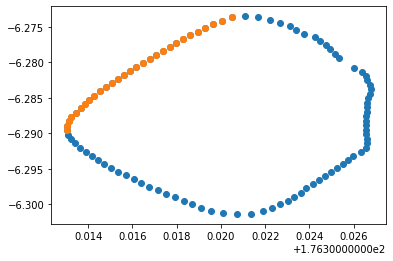

In [80]:
plt.scatter(df_shoreline_1.x,df_shoreline_1.y)
df_test = df_shoreline_1[df_shoreline_1.shoreline_direction>270]
plt.scatter(df_test.x,df_test.y)

In [84]:
shorelines_dict[(key[0],key[1],ID,year_beginning,year_end)]['shoreline_1']

,x,x+n,y,y+n,m_shoreline,m_transect,x_avg,y_avg,c_shoreline,c_transect,x_new,y_new,intersect_distance,transect_angle,erosion,avg_slope_change,shoreline_direction
0,176.326374,176.326534,-6.281287,-6.281900,-3.846220,0.259996,176.326454,-6.281593,671.908739,-52.125683,176.327422,-6.281342,-0.000011,14.573976,True,-13.181856,75.426024
1,176.326534,176.326608,-6.281900,-6.282531,-8.484946,0.117856,176.326571,-6.282216,1489.839273,-27.063322,176.327564,-6.282099,0.000009,6.721632,False,-2.172784,83.278368
2,176.326608,176.326721,-6.282531,-6.283157,-5.541999,0.180440,176.326665,-6.282844,970.919302,-38.099283,176.327649,-6.282667,0.000007,10.228408,False,-0.862632,79.771592
3,176.326721,176.326776,-6.283157,-6.283787,-11.438403,0.087425,176.326749,-6.283472,2010.613001,-21.698801,176.327745,-6.283385,-0.000011,4.996368,True,-6.505029,85.003632
4,176.326776,176.326745,-6.283787,-6.284422,20.581583,-0.048587,176.326761,-6.284105,-3635.367945,2.283106,176.327760,-6.284153,0.000016,-2.781650,False,-7.300853,92.781650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,176.324724,176.324950,-6.277536,-6.278131,-2.637033,0.379214,176.324837,-6.277834,458.696581,-73.142691,176.325772,-6.277479,-0.000093,20.767432,True,-1.995744,69.232568
97,176.324950,176.325149,-6.278131,-6.278734,-3.020467,0.331075,176.325050,-6.278432,526.305558,-64.655184,176.325999,-6.278118,-0.000045,18.318397,True,-0.946883,71.681603
98,176.325149,176.325355,-6.278734,-6.279336,-2.925147,0.341863,176.325252,-6.279035,509.498321,-66.558135,176.326199,-6.278711,-0.000032,18.873666,True,1.680007,71.126334
99,176.325355,176.325590,-6.279336,-6.279927,-2.515648,0.397512,176.325473,-6.279631,437.293144,-76.371111,176.326402,-6.279262,-0.000018,21.678411,True,7.105839,68.321589


In [86]:
df_shoreline_1

,x,x+n,y,y+n,m_shoreline,m_transect,x_avg,y_avg,c_shoreline,c_transect,x_new,y_new,intersect_distance,transect_angle,erosion,avg_slope_change,shoreline_direction
0,176.326374,176.326534,-6.281287,-6.281900,-3.846220,0.259996,176.326454,-6.281593,671.908739,-52.125683,176.327422,-6.281342,-0.000011,14.573976,True,-13.181856,75.426024
1,176.326534,176.326608,-6.281900,-6.282531,-8.484946,0.117856,176.326571,-6.282216,1489.839273,-27.063322,176.327564,-6.282099,0.000009,6.721632,False,-2.172784,83.278368
2,176.326608,176.326721,-6.282531,-6.283157,-5.541999,0.180440,176.326665,-6.282844,970.919302,-38.099283,176.327649,-6.282667,0.000007,10.228408,False,-0.862632,79.771592
3,176.326721,176.326776,-6.283157,-6.283787,-11.438403,0.087425,176.326749,-6.283472,2010.613001,-21.698801,176.327745,-6.283385,-0.000011,4.996368,True,-6.505029,85.003632
4,176.326776,176.326745,-6.283787,-6.284422,20.581583,-0.048587,176.326761,-6.284105,-3635.367945,2.283106,176.327760,-6.284153,0.000016,-2.781650,False,-7.300853,92.781650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,176.324724,176.324950,-6.277536,-6.278131,-2.637033,0.379214,176.324837,-6.277834,458.696581,-73.142691,176.325772,-6.277479,-0.000093,20.767432,True,-1.995744,69.232568
97,176.324950,176.325149,-6.278131,-6.278734,-3.020467,0.331075,176.325050,-6.278432,526.305558,-64.655184,176.325999,-6.278118,-0.000045,18.318397,True,-0.946883,71.681603
98,176.325149,176.325355,-6.278734,-6.279336,-2.925147,0.341863,176.325252,-6.279035,509.498321,-66.558135,176.326199,-6.278711,-0.000032,18.873666,True,1.680007,71.126334
99,176.325355,176.325590,-6.279336,-6.279927,-2.515648,0.397512,176.325473,-6.279631,437.293144,-76.371111,176.326402,-6.279262,-0.000018,21.678411,True,7.105839,68.321589


(array([ 6.,  0.,  1.,  2.,  8., 26., 49.,  5.,  1.,  3.]),
 array([-4.66557206e-04, -3.90725932e-04, -3.14894658e-04, -2.39063385e-04,
        -1.63232111e-04, -8.74008368e-05, -1.15695629e-05,  6.42617110e-05,
         1.40092985e-04,  2.15924259e-04,  2.91755533e-04]),
 <BarContainer object of 10 artists>)

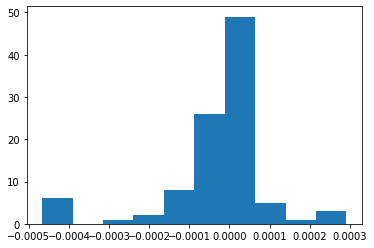

In [81]:
plt.hist(df_shoreline_1.intersect_distance)

In [25]:
# np.max(df_shoreline_1['shoreline_direction'])

In [26]:
# df_xr_atoll['dirr_adjust'] = (df_xr_atoll.dirr+90)
# for index,row in df_shoreline_1.iterrows(): 
#     df_xr_atoll['incidence_angle'] = (df_xr_atoll.dirr_adjust)-row.shoreline_direction
    
#     ##### Have a middle one.... in lots of 60 degrees left, right, straight on
#     # Split the wave incidence into 
#     df_xr_anti_clockwise = df_xr_atoll[(df_xr_atoll['incidence_angle']>0)&(df_xr_atoll['incidence_angle']<=90)|\
#                                        (df_xr_atoll['incidence_angle']+360>0)&(df_xr_atoll['incidence_angle']+360<=90)|\
#                                        (df_xr_atoll['incidence_angle']-360>0)&(df_xr_atoll['incidence_angle']-360<=90)]
#     df_xr_clockwise = df_xr_atoll[(df_xr_atoll['incidence_angle']<0)&(df_xr_atoll['incidence_angle']>=-90)|\
#                                   (df_xr_atoll['incidence_angle']+360<0)&(df_xr_atoll['incidence_angle']+360>=-90)|
#                                   (df_xr_atoll['incidence_angle']-360<0)&(df_xr_atoll['incidence_angle']-360>=-90)]

In [27]:
# df_xr_clockwise

In [28]:
# np.max(df_xr_clockwise.dirr_adjust)

In [87]:
from sklearn.cluster import KMeans


In [30]:
# row

# Testing to see if I have the data that I need for distributions in proxy model

In [31]:
def calc_sheltering(lats,lons,label,row):
    sheltered = []
    for lat,lon in zip(lats,lons):

        sheltered_per_islet = []
        for shoreline_1_poly in shoreline_poly_list:

            sheltered_per_islet.append(
                LineString([shapely.geometry.Point(row.x_new,row.y_new),
                   shapely.geometry.Point(lon,lat)]).intersects(shoreline_1_poly)
            )
        sheltered.append(any(sheltered_per_islet))
    row[label] = sum(sheltered)>sum([not x for x in sheltered])

    return(row)

In [139]:
df_transect_test = shorelines_dict[('Nanumea', 'TOB', 1, 2012, 2013)]['shoreline_1']
df_transect_test = df_transect_test[df_transect_test.intersect_distance!=np.max(df_transect_test.intersect_distance)]
df_transect_test = df_transect_test[df_transect_test.intersect_distance!=np.min(df_transect_test.intersect_distance)]
df_transect_test = df_transect_test[df_transect_test.intersect_distance!=np.min(df_transect_test.intersect_distance)]

df_transect_test.index.rename('position',inplace=True)

df_transect_test.reset_index(drop=False,inplace=True)

pvalues_per_clust = {}

# fig = plt.figure(figsize=(5,20))

for x in np.arange(2,9,1):
#     ax = plt.subplot2grid((9,1),((x-2),0))
    clusts = KMeans(n_clusters=x)
    clusts = clusts.fit(np.array(df_transect_test[var_list])).predict(np.array(df_transect_test[var_list]))
    df_transect_test[f'clust_{x}'] = clusts
#     ax.scatter(df_transect_test.x,df_transect_test.y,c=clusts)#df_transect_test.intersect_distance)
    pvalues_dict = {}
    for (c1,c2) in list(itertools.combinations(range(x),2)):
        mat1 = df_transect_test.loc[df_transect_test[f'clust_{x}']==c1,'intersect_distance']
        mat2 = df_transect_test.loc[df_transect_test[f'clust_{x}']==c2,'intersect_distance']
        
        pvalues_dict.update({
            (c1,c2):scipy.stats.ttest_ind(mat1,mat2).pvalue
        })
    pvalues_per_clust.update({
        x:pvalues_dict
    })
    
np.mean(pd.DataFrame.from_dict(pvalues_per_clust))<0.05

2     True
3    False
4    False
5    False
6    False
7    False
8    False
dtype: bool

In [140]:
np.mean(pd.DataFrame.from_dict(pvalues_per_clust))==np.min(np.mean(pd.DataFrame.from_dict(pvalues_per_clust)))

2     True
3    False
4    False
5    False
6    False
7    False
8    False
dtype: bool

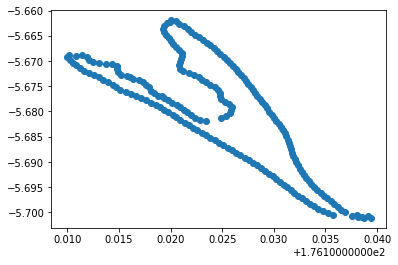

In [134]:
plt.scatter(df_transect_test.x,df_transect_test.y)

In [129]:
df_transect_test[var_list]

,x,y,position,shoreline_direction
0,176.133092,-5.697154,0,235.067321
1,176.131079,-5.694272,1,236.129041
2,176.129084,-5.691299,2,231.453230
3,176.126853,-5.688499,3,230.020019
4,176.124520,-5.685717,4,229.866813
5,176.122182,-5.682944,5,230.816045
6,176.119888,-5.680130,6,228.942293
7,176.117507,-5.677397,7,220.539923
8,176.114777,-5.675061,8,227.537908
9,176.112402,-5.672466,9,234.048879


## From df_transects, determine distributions

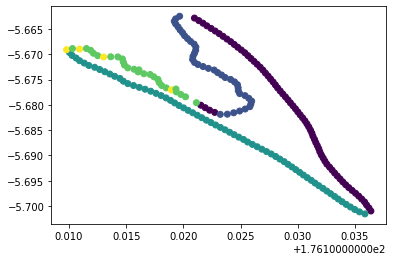

In [145]:
# have a look at some cluster diagrams
plt.scatter(df_transect_test.x,df_transect_test.y,c=df_transect_test['clust_5'])

1984

In [175]:
k

('Nanumaga', 'WM', 1, 2019, 2020)

In [176]:
shorelines_1_dict = {}

for k,v in shorelines_dict.items():
    v = v['shoreline_1']
    v['proxy'] = k[1]
    v['atoll'] = k[0]
    v['islet_id'] = k[2]
    v['year2'] = k[-1]
    shorelines_1_dict.update({k:v})


In [177]:
df_shoreline_1_compiled = pd.concat([shorelines_1_dict[x] for x in shorelines_1_dict.keys() if (x[0]=='Nanumea')])


In [182]:
vars_for_BN = ['proxy','atoll','islet_id','year2','intersect_distance']
df_shoreline_1_compiled = df_shoreline_1_compiled[vars_for_BN]

In [192]:
df_shoreline_1_compiled

,proxy,atoll,islet_id,year2,intersect_distance
0,TOB,Nanumea,1,1984,0.000467
1,TOB,Nanumea,1,1984,0.000384
2,TOB,Nanumea,1,1984,0.000144
3,TOB,Nanumea,1,1984,0.000099
4,TOB,Nanumea,1,1984,0.000070
...,...,...,...,...,...
30,WM,Nanumea,6,2024,0.001090
31,WM,Nanumea,6,2024,0.000473
32,WM,Nanumea,6,2024,0.000000
33,WM,Nanumea,6,2024,0.000580


In [230]:
df_TOB = df_shoreline_1_compiled[df_shoreline_1_compiled.proxy=='TOB'].rename(columns={'intersect_distance':'TOB'})
df_VL = df_shoreline_1_compiled[df_shoreline_1_compiled.proxy=='VL'].rename(columns={'intersect_distance':'VL'})
df_WM = df_shoreline_1_compiled[df_shoreline_1_compiled.proxy=='WM'].rename(columns={'intersect_distance':'WM'})

[x.set_index(['atoll','islet_id','year2'],inplace=True) for x in [df_TOB,df_VL,df_WM]]

[x.drop('proxy',axis=1,inplace=True) for x in [df_TOB,df_VL,df_WM]]

df_dataset_BN = df_TOB.join(df_VL,how='outer').join(df_WM,how='outer')
df_dataset_BN.reset_index(drop=False,inplace=True)
df_dataset_BN = df_dataset_BN[df_dataset_BN.islet_id==1]
df_dataset_BN.drop(['atoll','islet_id'],axis=1,inplace=True)
df_dataset_BN.to_csv('compiled_nanumea_shoreline.csv',index=False)

In [207]:
df_TOB


,proxy,atoll,islet_id,year2,intersect_distance
0,TOB,Nanumea,1,1984,0.000467
1,TOB,Nanumea,1,1984,0.000384
2,TOB,Nanumea,1,1984,0.000144
3,TOB,Nanumea,1,1984,0.000099
4,TOB,Nanumea,1,1984,0.000070
...,...,...,...,...,...
206,TOB,Nanumea,6,2020,0.000001
207,TOB,Nanumea,6,2020,0.000007
208,TOB,Nanumea,6,2020,0.000051
209,TOB,Nanumea,6,2020,0.000042


In [ ]:
for key in shorelines_dict.keys():
    

In [74]:
# shoreline_adjusted_dict = {}

# for index,row in df_transect_test.iterrows():

#     coords = np.arange(0.001,90,1)

#     delta_lons = [np.sqrt(np.tan(float(theta)*math.pi/180)**2/(1+np.tan(float(theta)*math.pi/180)**2)) for theta in coords]
#     delta_lats = [(1-delta_lon**2)**0.5 for delta_lon in delta_lons]

#     lons_q1 = [row.x_avg+delta_lon for delta_lon in delta_lons]
#     lats_q1 = [row.y_avg+delta_lat for delta_lat in delta_lats]
#     lons_q2 = [row.x_avg+delta_lon for delta_lon in delta_lons]
#     lats_q2 = [row.y_avg-delta_lat for delta_lat in delta_lats]
#     lons_q3 = [row.x_avg-delta_lon for delta_lon in delta_lons]
#     lats_q3 = [row.y_avg-delta_lat for delta_lat in delta_lats]
#     lons_q4 = [row.x_avg-delta_lon for delta_lon in delta_lons]
#     lats_q4 = [row.y_avg+delta_lat for delta_lat in delta_lats]

#     lats_q2.reverse()
#     lons_q2.reverse()
#     lats_q4.reverse()
#     lons_q4.reverse()

#     lats = lats_q1+lats_q2+lats_q3+lats_q4
#     lons = lons_q1+lons_q2+lons_q3+lons_q4

#     df_coords = pd.DataFrame.from_dict({k:{'lat':v1,'lon':v2} for k,v1,v2 in zip(np.arange(0.001,360,1),lats,lons)}).T

#     df_coords.index-=row.shoreline_direction

#     df_coords_right = df_coords[(df_coords.index>30)&(df_coords.index<=90)|\
#                                        (df_coords.index+360>30)&(df_coords.index+360<=90)|\
#                                        (df_coords.index-360>30)&(df_coords.index-360<=90)]

#     df_coords_mid = df_coords[(df_coords.index>-30)&(df_coords.index<=30)|\
#                                        (df_coords.index+360>-30)&(df_coords.index+360<=30)|\
#                                        (df_coords.index-360>-30)&(df_coords.index-360<=30)]

#     df_coords_left = df_coords[(df_coords.index<-30)&(df_coords.index>=-90)|\
#                                   (df_coords.index+360<-30)&(df_coords.index+360>=-90)|
#                                   (df_coords.index-360<-30)&(df_coords.index-360>=-90)]

#     df_coords.index+=row.shoreline_direction
#     df_coords_left.index+=row.shoreline_direction
#     df_coords_mid.index+=row.shoreline_direction
#     df_coords_right.index+=row.shoreline_direction

#     row = calc_sheltering(df_coords_left.lat,df_coords_left.lon,'left',row)
#     row = calc_sheltering(df_coords_mid.lat,df_coords_mid.lon,'mid',row)
#     row = calc_sheltering(df_coords_right.lat,df_coords_right.lon,'right',row)
    
#     shoreline_adjusted_dict.update({
#         index:row
#     })   
    
# df_transect_test = pd.DataFrame.from_dict(shoreline_adjusted_dict)


In [75]:
# df_transect_test = df_transect_test.T
# df_transect_test

In [76]:
from sklearn.cluster import KMeans

In [ ]:
fig = plt.figure(figsize=(14,10))

var_list = ['x','y','position','shoreline_direction']

clusts = KMeans(n_clusters=2,
                algorithm='elkan'
               ).fit(np.array(df_transect_test[var_list])).predict(np.array(df_transect_test[var_list]))

#['r' if x==False else 'b' for x in df_transect_test.erosion]

output = plt.scatter(df_transect_test.x,df_transect_test.y,c=clusts)#df_transect_test.intersect_distance)

plt.colorbar(output)

2     True
3     True
4     True
5    False
6    False
7    False
8    False
dtype: bool

<Figure size 360x1440 with 0 Axes>

2     True
3     True
4     True
5    False
6    False
7    False
8    False
dtype: bool

In [66]:
import scipy

0.008950369239021148

In [48]:
clusts

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=int32)

In [59]:
df_transect_test[f'clust_{x}']==c1

0      False
1      False
2      False
3       True
4       True
       ...  
203    False
204    False
205    False
206    False
207    False
Name: clust_8, Length: 208, dtype: bool

In [60]:
df_transect_test

,position,x,x+n,y,y+n,m_shoreline,m_transect,x_avg,y_avg,c_shoreline,...,erosion,avg_slope_change,shoreline_direction,clust_2,clust_3,clust_4,clust_5,clust_6,clust_7,clust_8
0,0,176.125347,176.125785,-5.680864,-5.680389,1.085715,-0.921052,176.125566,-5.680626,-196.902782,...,False,21.693658,312.646686,1,2,3,3,2,3,2
1,1,176.125785,176.125876,-5.680389,-5.679758,6.909212,-0.144734,176.125830,-5.680073,-1222.570686,...,False,18.027340,278.235478,1,2,3,3,2,3,2
2,2,176.125876,176.125949,-5.679758,-5.679128,8.653320,-0.115563,176.125912,-5.679443,-1529.753403,...,False,18.303051,276.592007,1,2,3,3,2,3,2
3,3,176.125949,176.125642,-5.679128,-5.678559,-1.851730,0.540036,176.125795,-5.678843,320.458557,...,False,23.011825,241.629376,1,2,3,3,2,3,6
4,4,176.125642,176.125238,-5.678559,-5.678068,-1.216050,0.822335,176.125440,-5.678314,208.499041,...,False,4.640645,230.568358,1,2,3,3,2,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,206,176.121953,176.122366,-5.680704,-5.681208,-1.219878,0.819754,176.122159,-5.680956,209.166675,...,False,4.335061,50.656684,0,0,2,2,3,4,3
204,207,176.122366,176.122848,-5.681208,-5.681643,-0.902689,1.107802,176.122607,-5.681425,153.302430,...,False,10.985453,42.072204,0,0,2,2,3,4,3
205,208,176.122848,176.123412,-5.681643,-5.681951,-0.547161,1.827614,176.123130,-5.681797,90.685981,...,False,28.929863,28.685777,0,0,2,2,3,4,3
206,209,176.123412,176.124027,-5.681951,-5.681777,0.282736,-3.536865,176.123719,-5.681864,-55.478427,...,False,33.531491,344.212478,1,1,1,4,5,5,7


In [49]:
list(range(x))

[0, 1]

In [47]:
np.arange(1,x+1,1)

array([1, 2])

In [56]:

    print(c1)


0


In [ ]:
asdf

In [ ]:
range(2)

In [ ]:
np.min(df_transect_test.intersect_distance)

In [ ]:
df_transect_test


# Plotting the Result

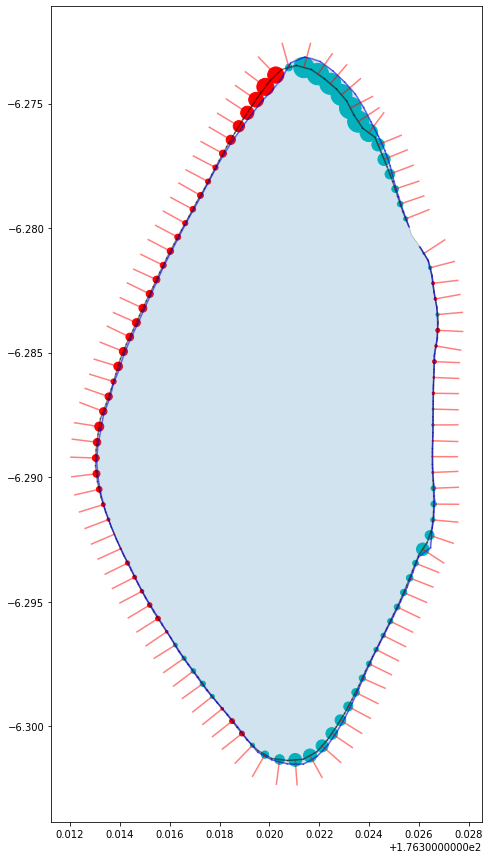

In [88]:
fig = plt.figure(figsize=(15,15))

ax = plt.subplot2grid((1,1),(0,0))

[ax.plot([x,x_n],[y,y_n],alpha=0.5,c='k') for x,x_n,y,y_n in zip(
    df_shoreline_1['x'],
    df_shoreline_1['x+n'],
    df_shoreline_1['y'],
    df_shoreline_1['y+n']
)]

[ax.plot([x,x_n],[y,y_n],alpha=0.5,c='b') for x,x_n,y,y_n in zip(
    df_shoreline_2['x'],
    df_shoreline_2['x+n'],
    df_shoreline_2['y'],
    df_shoreline_2['y+n']
)]

df_shoreline_erosion = df_shoreline_1[df_shoreline_1.erosion==True]
ax.scatter(df_shoreline_erosion['x_avg'],df_shoreline_erosion['y_avg'],s=[-x*1000000 for x in df_shoreline_erosion['intersect_distance']],
            alpha=1,c='c',zorder=-1000)

df_shoreline_acretion = df_shoreline_1[df_shoreline_1.erosion==False]
ax.scatter(df_shoreline_acretion['x_avg'],df_shoreline_acretion['y_avg'],s=1000000*df_shoreline_acretion['intersect_distance'],
            alpha=1,c='r',zorder=-1000)

[ax.plot([x_avg,x_proj],[y_avg,y_proj],alpha=0.5,c='r') for x_avg,x_proj,y_avg,y_proj in zip(
    df_shoreline_1['x_avg'],
    df_shoreline_1['x_new'],
    df_shoreline_1['y_avg'],
    df_shoreline_1['y_new']
)]

# ax.set_xlim(177.5,177.75)
# ax.set_ylim(-6.305,-6.27)
ax.set_aspect('equal', adjustable='box')

ax.add_patch(descartes.PolygonPatch(end_year_poly,alpha=0.2))

# plt.plot(x_test,y_test,c='b')

plt.show()

/tmp/ipykernel_683/1286431431.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shoreline_1_concave['avg_slope_change'] = np.abs(df_shoreline_1_concave.avg_slope_change)


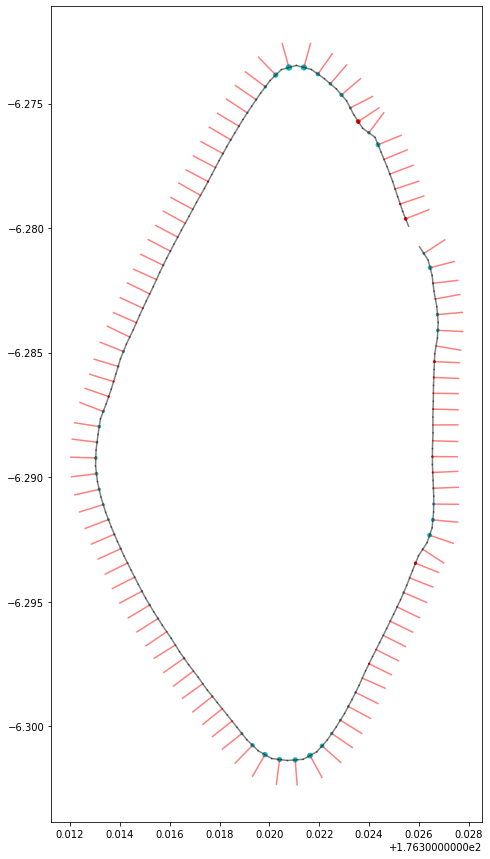

In [89]:
fig = plt.figure(figsize=(15,15))

ax = plt.subplot2grid((1,1),(0,0))

[ax.plot([x,x_n],[y,y_n],alpha=0.5,c='k') for x,x_n,y,y_n in zip(
    df_shoreline_1['x'],
    df_shoreline_1['x+n'],
    df_shoreline_1['y'],
    df_shoreline_1['y+n']
)]

df_shoreline_1_concave = df_shoreline_1[df_shoreline_1.avg_slope_change<0]
df_shoreline_1_concave['avg_slope_change'] = np.abs(df_shoreline_1_concave.avg_slope_change)
df_shoreline_1_convex = df_shoreline_1[df_shoreline_1.avg_slope_change>0]

ax.scatter(df_shoreline_1_concave['x_avg'],df_shoreline_1_concave['y_avg'],s=1*df_shoreline_1_concave['avg_slope_change'],
            alpha=1,c='c',zorder=-1000)
ax.scatter(df_shoreline_1_convex['x_avg'],df_shoreline_1_convex['y_avg'],s=1*df_shoreline_1_convex['avg_slope_change'],
            alpha=1,c='r',zorder=-1000)

[ax.plot([x_avg,x_proj],[y_avg,y_proj],alpha=0.5,c='r') for x_avg,x_proj,y_avg,y_proj in zip(
    df_shoreline_1['x_avg'],
    df_shoreline_1['x_new'],
    df_shoreline_1['y_avg'],
    df_shoreline_1['y_new']
)]

# ax.set_xlim(177.5,177.75)
# ax.set_ylim(-6.305,-6.27)
ax.set_aspect('equal', adjustable='box')

# ax.add_patch(descartes.PolygonPatch(alpha_shape,alpha=0.2))

# plt.plot(x_test,y_test,c='b')

plt.show()

# Determine if you are in the shoreline and the lagoon

In [ ]:
# atoll = 'Nanumea'
# proxy = 'TOB'

# shoreline_poly_list = []

# ids = id_dict[(atoll,proxy)]

# for idx in ids:
#     df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, 1971, 1984)]['shoreline_1'].copy()
#     df_xy_1 = shorelines_dict[(atoll, proxy, idx, 1971, 1984)]['shoreline_1'].copy()
#     shoreline_1_poly = shapely.ops.transform(lambda x, y: (y, x),
#                               shapely.geometry.Polygon([(y,x) for x,y in zip(df_shoreline_1.x,df_shoreline_1.y)])
#                                             )
    
#     shoreline_poly_list.append(
#         shoreline_1_poly
#     )


In [ ]:
def calc_sheltering(lats,lons,label,row):
    sheltered = []
    for lat,lon in zip(lats,lons):

        sheltered_per_islet = []
        for shoreline_1_poly in shoreline_poly_list:

            sheltered_per_islet.append(
                LineString([shapely.geometry.Point(row.x_new,row.y_new),
                   shapely.geometry.Point(lon,lat)]).intersects(shoreline_1_poly)
            )
        sheltered.append(any(sheltered_per_islet))
    row[label] = sum(sheltered)>sum([not x for x in sheltered])

    return(row)

delta_lons = [np.sqrt(1/(1+np.tan(theta)**2)) for theta in np.arange(0,360,15)*math.pi/180]
delta_lats = [np.sqrt(np.tan(theta)**2/(1+np.tan(theta)**2)) for theta in np.arange(0,360,15)*math.pi/180]

combinations = []
for key in list(shorelines_dict.keys()):
    combinations.append((key[0],key[1],key[3],key[4]))
    
combinations = [t for t in (set(combinations))]

for key in combinations:
    print(key)
    atoll = key[0]
    proxy = key[1]
    beginning_year = key[2]
    end_year = key[3]

    shoreline_poly_list = []

    ids = []
    for n in np.arange(0,20,1):
        try:
            shorelines_dict[(atoll,proxy,n,beginning_year,end_year)]
            ids.append(n)
        except:
            continue

    for idx in ids:
        df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)]['shoreline_1'].copy()
        df_xy_1 = shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)]['shoreline_1'].copy()
        shoreline_1_poly = shapely.ops.transform(lambda x, y: (y, x),
                                  shapely.geometry.Polygon([(y,x) for x,y in zip(df_shoreline_1.x,df_shoreline_1.y)])
                                                )

        shoreline_poly_list.append(
            shoreline_1_poly
        )

    i=0
    for idx in ids:
        df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)]['shoreline_1'].copy()

        shoreline_1_dict = {}

        for index,row in df_shoreline_1.iterrows():

            coords = np.arange(0.001,90,1)

            delta_lons = [np.sqrt(np.tan(float(theta)*math.pi/180)**2/(1+np.tan(float(theta)*math.pi/180)**2)) for theta in coords]
            delta_lats = [(1-delta_lon**2)**0.5 for delta_lon in delta_lons]

            lons_q1 = [row.x_avg+delta_lon for delta_lon in delta_lons]
            lats_q1 = [row.y_avg+delta_lat for delta_lat in delta_lats]
            lons_q2 = [row.x_avg+delta_lon for delta_lon in delta_lons]
            lats_q2 = [row.y_avg-delta_lat for delta_lat in delta_lats]
            lons_q3 = [row.x_avg-delta_lon for delta_lon in delta_lons]
            lats_q3 = [row.y_avg-delta_lat for delta_lat in delta_lats]
            lons_q4 = [row.x_avg-delta_lon for delta_lon in delta_lons]
            lats_q4 = [row.y_avg+delta_lat for delta_lat in delta_lats]

            lats_q2.reverse()
            lons_q2.reverse()
            lats_q4.reverse()
            lons_q4.reverse()

            lats = lats_q1+lats_q2+lats_q3+lats_q4
            lons = lons_q1+lons_q2+lons_q3+lons_q4

            df_coords = pd.DataFrame.from_dict({k:{'lat':v1,'lon':v2} for k,v1,v2 in zip(np.arange(0.001,360,1),lats,lons)}).T

            df_coords.index-=row.shoreline_direction

            df_coords_right = df_coords[(df_coords.index>30)&(df_coords.index<=90)|\
                                               (df_coords.index+360>30)&(df_coords.index+360<=90)|\
                                               (df_coords.index-360>30)&(df_coords.index-360<=90)]

            df_coords_mid = df_coords[(df_coords.index>-30)&(df_coords.index<=30)|\
                                               (df_coords.index+360>-30)&(df_coords.index+360<=30)|\
                                               (df_coords.index-360>-30)&(df_coords.index-360<=30)]

            df_coords_left = df_coords[(df_coords.index<-30)&(df_coords.index>=-90)|\
                                          (df_coords.index+360<-30)&(df_coords.index+360>=-90)|
                                          (df_coords.index-360<-30)&(df_coords.index-360>=-90)]

            df_coords.index+=row.shoreline_direction
            df_coords_left.index+=row.shoreline_direction
            df_coords_mid.index+=row.shoreline_direction
            df_coords_right.index+=row.shoreline_direction

            row = calc_sheltering(df_coords_left.lat,df_coords_left.lon,'left',row)
            row = calc_sheltering(df_coords_mid.lat,df_coords_mid.lon,'mid',row)
            row = calc_sheltering(df_coords_right.lat,df_coords_right.lon,'right',row)
            
#             df_xr_atoll['incidence_angle'] = (df_xr_atoll.dirr_adjust)-row.shoreline_direction

#             ##### Have a middle one.... in lots of 60 degrees left, right, straight on
#             # Split the wave incidence into 
#             df_xr_right = df_xr_atoll[(df_xr_atoll['incidence_angle']>30)&(df_xr_atoll['incidence_angle']<=90)|\
#                                                (df_xr_atoll['incidence_angle']+360>30)&(df_xr_atoll['incidence_angle']+360<=90)|\
#                                                (df_xr_atoll['incidence_angle']-360>30)&(df_xr_atoll['incidence_angle']-360<=90)]
            
#             df_xr_mid = df_xr_atoll[(df_xr_atoll['incidence_angle']>-30)&(df_xr_atoll['incidence_angle']<=30)|\
#                                                (df_xr_atoll['incidence_angle']+360>-30)&(df_xr_atoll['incidence_angle']+360<=30)|\
#                                                (df_xr_atoll['incidence_angle']-360>-30)&(df_xr_atoll['incidence_angle']-360<=30)]
            
#             df_xr_left = df_xr_atoll[(df_xr_atoll['incidence_angle']<-30)&(df_xr_atoll['incidence_angle']>=-90)|\
#                                           (df_xr_atoll['incidence_angle']+360<-30)&(df_xr_atoll['incidence_angle']+360>=-90)|
#                                           (df_xr_atoll['incidence_angle']-360<-30)&(df_xr_atoll['incidence_angle']-360>=-90)]

            shoreline_1_dict.update({
                index:row
            })

        df_shoreline_1 = pd.DataFrame.from_dict(shoreline_1_dict,orient='index')

        shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)].update({
            'shoreline_1':df_shoreline_1
        })            
            

In [ ]:
shorelines_dict.keys()

In [ ]:
# df_shoreline_1 = pd.DataFrame.from_dict(shoreline_1_dict,orient='index')

In [ ]:
# df_xr_atoll

In [ ]:
# for idx in ids:
#     df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)]['shoreline_1']
    
#     plt.scatter(df_shoreline_1.x,df_shoreline_1.y)
    
    

In [ ]:
# coord_adjust = [180-coord if (coord>90)&(coord<180) else coord for coord in coords]
# coord_adjust = [180+coord if (coord>180)&(coord<270) else coord for coord in coords]
# coord_adjust = [360-coord if (coord>270)&(coord<360) else coord for coord in coords]

    
# delta_lons = [-delta_lon if (coord>180) else delta_lon for delta_lon,coord in zip(delta_lons,coords)]
# delta_lats = [-delta_lat if (coord>90)&(coord>270) else delta_lat for delta_lat,coord in zip(delta_lats,coords)]

In [ ]:
# coords = np.arange(0,360,1)
# angle = 180
# coords = coords[((coords>(angle-90))&(coords<(angle+90)))|\
#        (((coords+360)>(angle-90))&((coords+360)<(angle+90)))|\
#        (((coords)>(angle+360-90))&((coords)<(angle+360+90)))]
# coords


# Look at the correlation between these variables and the change in shoreline

In [ ]:
df_combined_shoreline_change = pd.concat({keys:dicts['shoreline_1'] for keys,dicts in shorelines_dict.items()})
df_combined_shoreline_change = \
    df_combined_shoreline_change.reset_index(drop=False).rename(columns={
        'level_0':'atoll',
        'level_1':'proxy',
        'level_2':'islet_id',
        'level_3':'beginning_year',
        'level_4':'end_year'
    }).drop('level_5',axis=1)

In [ ]:
# Round the shoreline direction to the nearest 45 degrees
df_combined_shoreline_change['shoreline_direction'] = (df_combined_shoreline_change.shoreline_direction/45).round()*45
df_combined_shoreline_change['avg_slope_change'] = (df_combined_shoreline_change.avg_slope_change/45).round()*45


In [ ]:

def create_boxplot(var,ax):
    x=0
    xticks_list = []
    for key,group in df_combined_shoreline_change.groupby(var):
        ax.violinplot(dataset=group.intersect_distance,positions=[x])
        x+=1
        xticks_list.append(key)

#     ax.set_xticklabels(xticks_list)
    ax.set(xlim=(-1,x),xticks=np.arange(0,x,1))
    ax.set_xticklabels(xticks_list)
    ax.set_ylabel('Shoreline change')
    ax.set_title('Variable: {}'.format(var))
    
    return(ax)

fig = plt.figure(figsize=(15,25))

ax1 = plt.subplot2grid((5,2),(0,0))
ax2 = plt.subplot2grid((5,2),(0,1))
ax3 = plt.subplot2grid((5,2),(1,0))
ax4 = plt.subplot2grid((5,2),(1,1))
ax5 = plt.subplot2grid((5,2),(2,0))
ax6 = plt.subplot2grid((5,2),(2,1))
ax7 = plt.subplot2grid((5,2),(3,0))
ax8 = plt.subplot2grid((5,2),(3,1))
ax9 = plt.subplot2grid((5,2),(4,0))
ax10 = plt.subplot2grid((5,2),(4,1))

ax1 = create_boxplot('proxy',ax1)
ax2 = create_boxplot('atoll',ax2)
ax3 = create_boxplot('islet_id',ax3)
ax4 = create_boxplot('shoreline_direction',ax4)
ax5 = create_boxplot('left',ax5)
ax6 = create_boxplot('mid',ax6)
ax7 = create_boxplot('right',ax7)
ax9 = create_boxplot('avg_slope_change',ax9)



In [ ]:
key_vars = ['proxy','atoll','islet_id','shoreline_direction','left','mid','right','avg_slope_change','intersect_distance']

corr = df_combined_shoreline_change[key_vars].corr()

In [ ]:
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.imshow(corr)

In [ ]:
corr

In [ ]:
df_combined_shoreline_change

In [ ]:
plt.hist(df_combined_shoreline_change.intersect_distance)

In [ ]:
%%R -i df_combined_shoreline_change -o intersect_distance_summary

intersect_distance_summary = summary(df_combined_shoreline_change$intersect_distance)
intersect_distance_summary


In [ ]:
intersect_distance_summary

In [ ]:
q1 = intersect_distance_summary[1]
q3 = intersect_distance_summary[3]

In [ ]:
df_combined_shoreline_change_extremes = df_combined_shoreline_change[(df_combined_shoreline_change.intersect_distance<-0.001)|(df_combined_shoreline_change.intersect_distance>0.001)]

In [ ]:
plt.hist(df_combined_shoreline_change_extremes.intersect_distance)

In [ ]:
print(df_combined_shoreline_change_extremes[key_vars].corr().intersect_distance)

In [ ]:
key_vars = ['proxy','shoreline_direction','left','mid','right','avg_slope_change','intersect_distance']
corr_dict = {}
for key,group in df_combined_shoreline_change_extremes.groupby(['atoll','islet_id']):
    corr_dict.update({
        key:group[key_vars].corr().intersect_distance.to_dict()
    })

In [ ]:
pd.DataFrame.from_dict(corr_dict,orient='index')

# Looking at the change in shoreline on a per year basis

In [ ]:
df_combined_shoreline_change_extremes.loc[:,'shoreline_direction_scaled'] = \
    [(x+180)/(360) for x in list(df_combined_shoreline_change_extremes.shoreline_direction)]
df_combined_shoreline_change_extremes['intersect_distance_per_year'] = \
    [x.intersect_distance/(x.end_year-x.beginning_year) for idx,x in df_combined_shoreline_change_extremes.iterrows()]

fig1 = plt.figure(figsize=(15,15))

ax1 = plt.subplot2grid((3,3),(0,0))
ax2 = plt.subplot2grid((3,3),(0,1))
ax3 = plt.subplot2grid((3,3),(0,2))
ax4 = plt.subplot2grid((3,3),(1,0))
ax5 = plt.subplot2grid((3,3),(1,1))
ax6 = plt.subplot2grid((3,3),(1,2))
ax7 = plt.subplot2grid((3,3),(2,0))
ax8 = plt.subplot2grid((3,3),(2,1))
ax9 = plt.subplot2grid((3,3),(2,2))

for ax,(key,group) in zip([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9],
                          df_combined_shoreline_change_extremes.groupby(['atoll','islet_id'])
                         ):
    ax.scatter(group.avg_slope_change,group.intersect_distance_per_year,c=group.shoreline_direction_scaled,alpha=0.5)

## How well can a linear model explain the variance

In [ ]:
from statsmodels.formula.api import ols

In [ ]:
corr_dict = {}
for key,group in df_combined_shoreline_change_extremes.groupby(['atoll','islet_id']):
    print('\033[1m'+str(key)+'\033[0m')
    model = ols(
        "intersect_distance ~ proxy + shoreline_direction + left + mid + right + avg_slope_change",
        data=group).fit()
    print(model.params)
    print(model.summary())
    print('')

In [ ]:
corr_dict = {}
for key,group in df_combined_shoreline_change_extremes.groupby(['atoll','islet_id']):
    print('\033[1m'+str(key)+'\033[0m')
    group.intersect_distance_per_year = -group.intersect_distance_per_year
    model = ols(
        "intersect_distance_per_year ~ proxy + shoreline_direction + left + mid + right + avg_slope_change",
        data=group).fit()
    print(model.params)
    print(model.summary())
    print('')

## Adding Waves Features

In [ ]:
# for index,row in df_combined_shoreline_change.iterrows():
#     waves_per_atoll_year_dict[(row.atoll,row.proxy,beginning_year,end_year)]

In [ ]:
# waves_per_atoll_year_dict[('Nanumea', 'TOB', 1971, 1984)]

In [ ]:
combined_wave_shoreline_stats_dict = {}

# Loop over each row and add wave stats
for index,row in df_combined_shoreline_change.iterrows():
    # For this atoll-proxy-year combination, get the corresponding wave stats dict
    try:
        df_wave_features = pd.concat({key:pd.DataFrame.from_dict(item,orient='index')
         for key,item in waves_per_atoll_year_dict[(row.atoll,row.proxy,row.beginning_year,row.end_year)].items()})
    except:
        print((row.atoll,row.proxy,row.beginning_year,row.end_year))
        continue
        
    # Format the wave stats so that they can be added to the row
    df_wave_features = df_wave_features.reset_index().rename(columns={'level_0':'freq1','level_1':'freq2','level_2':'dirr'})
    df_wave_features = df_wave_features.melt(['freq1','freq2','dirr']).rename(columns={'variable':'stat'})
    df_wave_features.index = \
        [(freq1,freq2,dirr,stat) for freq1,freq2,dirr,stat in zip(
            df_wave_features.freq1,df_wave_features.freq2,df_wave_features.dirr,df_wave_features.stat
        )]
    # Combine the wave stats into the row
    df_wave_features = df_wave_features['value'].T
    row = pd.concat([row,df_wave_features])
    
    # Add to a dictionary
    combined_wave_shoreline_stats_dict.update({
        index:row
    })
    
# get the wave feature list 
wave_features_list = list(df_wave_features.index)

# Combine into a single dataframe
df_combined_wave_shoreline_change = pd.DataFrame.from_dict(combined_wave_shoreline_stats_dict,orient='index')

In [ ]:
df_combined_wave_shoreline_change

## Correlations between shoreline change and previous year

In [ ]:
key_vars = ['proxy','atoll','islet_id','shoreline_direction','left','mid','right','avg_slope_change','intersect_distance']
key_vars = wave_features_list+key_vars

corr = df_combined_wave_shoreline_change[key_vars].corr()

In [ ]:
corr['intersect_distance']

In [ ]:
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.imshow(corr)

# Beach Sheltering

In [ ]:
key_vars = ['x','y','x_avg','y_avg','m_transect','c_transect','proxy','atoll','islet_id','shoreline_direction','left','mid','right','avg_slope_change','intersect_distance']
key_vars = wave_features_list+key_vars

df_test = df_combined_wave_shoreline_change[key_vars]

In [ ]:
df_test

In [ ]:
# For each direction, get the column names for each quadrant
left_features = [x for x in list(df_test) if 'left' in x]
mid_features = [x for x in list(df_test) if 'mid' in x]
right_features = [x for x in list(df_test) if 'right' in x]

left_features.remove('left')
mid_features.remove('mid')
right_features.remove('right')


In [ ]:
# This isn't going to work anymore

In [ ]:
df_left = pd.DataFrame.from_dict({
    str(i):
        [wave if shelter is False else 0 for wave,shelter in zip(df_test[i],df_test.left_features)] for i in left_features
})

df_mid = pd.DataFrame.from_dict({
    str(i):
        [wave if shelter is False else 0 for wave,shelter in zip(df_test[i],df_test.ES_sheltered)] for i in ES_features
})

df_SW_sheltered = pd.DataFrame.from_dict({
    str(i):
        [wave if shelter is False else 0 for wave,shelter in zip(df_test[i],df_test.SW_sheltered)] for i in SW_features
})

df_WN_sheltered = pd.DataFrame.from_dict({
    str(i):
        [wave if shelter is False else 0 for wave,shelter in zip(df_test[i],df_test.WN_sheltered)] for i in WN_features
})

In [ ]:
# df_sheltered = pd.concat([df_NE_sheltered,df_ES_sheltered,df_SW_sheltered,df_WN_sheltered])
df_sheltered = df_NE_sheltered.join(df_ES_sheltered).join(df_SW_sheltered).join(df_WN_sheltered)

In [ ]:
key_vars = ['x','y','x_avg','y_avg','m_transect','c_transect','proxy','atoll','islet_id','shoreline_direction','beginning_year','end_year','left','mid','right','avg_slope_change','intersect_distance']
df_combined_shoreline_change_sheltered = df_combined_shoreline_change[key_vars].join(df_sheltered)

In [ ]:
df_combined_shoreline_change_sheltered.corr()['intersect_distance']

# Shoreline Change through time

In [ ]:
# See how the shoreline has changed for a single proxy through time
atoll = 'Nanumea'
# proxy = 'VL'
islet_id = 2

for proxy in ['VL','TOB','WM']:
    df_single_atoll_proxy = df_combined_shoreline_change[
        (df_combined_shoreline_change.atoll==atoll)&(df_combined_shoreline_change.proxy==proxy)&(df_combined_shoreline_change.islet_id==islet_id)
        ]

    # get the beginning year only
    df_single_atoll_proxy_year_1 = \
        df_single_atoll_proxy[
            df_single_atoll_proxy.beginning_year==np.min(df_single_atoll_proxy.beginning_year)
        ].reset_index(drop=True)

    # Pick a random row
    x_init,y_init = df_single_atoll_proxy_year_1.loc[sample(list(df_single_atoll_proxy_year_1.index),1)[0],['x','y']]

    # Pick a single point as the first point in the timeseries
    # x_init,y_init = df_single_atoll_proxy.loc[df_single_atoll_proxy.sample(1).index,['x','y']]

    # get the closest part of the shoreline in subsequent years
    intersect_dist_per_year_dict = {}
    for index,group in df_single_atoll_proxy.groupby(['beginning_year','end_year']):
        group['dist'] = ((group.x-x_init)**2+(group.y-y_init)**2)**0.5
        dist, = group.loc[(group.dist==np.min(group.dist)),'intersect_distance']

        intersect_dist_per_year_dict.update({
            index:dist
        })

    # Format dictionary into a dataframe
    df_intersect_dist_per_year = pd.DataFrame.from_dict(intersect_dist_per_year_dict,orient='index')
    df_intersect_dist_per_year['beginning_year'] = [x[0] for x in df_intersect_dist_per_year.index]
    df_intersect_dist_per_year['end_year'] = [x[1] for x in df_intersect_dist_per_year.index]
    df_intersect_dist_per_year = df_intersect_dist_per_year.reset_index(drop=True).rename(columns={0:'intersect_distance'})

    # Get the running shoreline change
    df_intersect_dist_per_year['shoreline_movement'] = df_intersect_dist_per_year.intersect_distance.cumsum()

    # Plot the results
    plt.scatter(df_intersect_dist_per_year.beginning_year,df_intersect_dist_per_year.shoreline_movement)

plt.show()

# Lag variables

In [ ]:
lag_combos_dict = {}

# Loop over each combination and get the intersect_distance for the closest point in the previous year
for key,group in df_combined_shoreline_change.groupby(['atoll','islet_id','proxy']):
    
    # Get list of the beginning years
    beginning_years = np.unique(group.beginning_year)
    beginning_years = np.sort(beginning_years)

    lag_combos_per_year_dict = {}
    # Loop over each year and add the lag variables
    for year1,year2 in zip(beginning_years[:-1],beginning_years[1:]):
        df_year1 = group[group.beginning_year==year1]
        df_year2 = group[group.beginning_year==year2]

        lag_intersect_dict = {}
        for index,row in df_year2.iterrows():

            df_year1.loc[:,'closest_point'] = list(((df_year1.x-row.x)**2+(df_year1.y-row.y)**2)**0.5)
            df_year1 = df_year1.sort_values('closest_point').reset_index(drop=True)
            last_year_change = df_year1.loc[0,'intersect_distance']
            last_year_change_surroundings = np.mean(df_year1.loc[1:9,'intersect_distance'])

            row['lag_intersect_distance'] = last_year_change
            row['lag_intersect_distance_surroundings'] = last_year_change_surroundings

            lag_intersect_dict.update({
                index:row
            })

        df_combined_shoreline_lag_one_combo = pd.DataFrame.from_dict(lag_intersect_dict,orient='index')
        
        lag_combos_per_year_dict.update({
            year2:df_combined_shoreline_lag_one_combo
        })
    
    lag_combos_dict.update({
        key:pd.concat(lag_combos_per_year_dict)
    })
    
df_combined_shoreline_lag = pd.concat(lag_combos_dict).reset_index(drop=True)

In [ ]:
for index,group in df_combined_shoreline_lag.groupby(['proxy','islet_id','atoll']):
    print(
        index,
        group[['lag_intersect_distance_surroundings','lag_intersect_distance','intersect_distance']].corr().loc[
            ['lag_intersect_distance','lag_intersect_distance_surroundings'],'intersect_distance'
        ]
    )

# Combine into dataframe for BN

In [ ]:
list(df_combined_shoreline_change_sheltered)

In [ ]:
df_wave_vars = df_combined_shoreline_change_sheltered[
    ['x','y','x_avg','y_avg','m_transect','c_transect','proxy', 'atoll', 'islet_id','beginning_year','end_year', 'shoreline_direction', 'avg_slope_change', 'intersect_distance',"(0.033, 0.1997, 'NE', 'mean')","(0.1997, 1.0, 'NE', 'mean')","(0.033, 0.1997, 'ES', 'mean')","(0.1997, 1.0, 'ES', 'mean')","(0.033, 0.1997, 'SW', 'mean')","(0.1997, 1.0, 'SW', 'mean')","(0.033, 0.1997, 'WN', 'mean')","(0.1997, 1.0, 'WN', 'mean')"]
].set_index(['x','y','x_avg','y_avg','m_transect','c_transect','proxy','islet_id','atoll','beginning_year','end_year','intersect_distance'])
# list(df_combined_shoreline_lag)

In [ ]:
df_lag_vars = df_combined_shoreline_lag[
    ['x','y','x_avg','y_avg','m_transect','c_transect','atoll',
 'proxy',
 'islet_id',
 'beginning_year',
 'end_year',
 'lag_intersect_distance',
 'lag_intersect_distance_surroundings',
 'intersect_distance']
].set_index(['x','y','proxy','islet_id','atoll','beginning_year','end_year','intersect_distance'])

In [ ]:
df_for_bn =\
    pd.merge(df_wave_vars,
             df_lag_vars,
             on=['x','y','x_avg','y_avg','m_transect','c_transect','proxy','islet_id','atoll','beginning_year','end_year','intersect_distance'])

In [ ]:
df_for_bn.to_csv('wave_lag_vars.csv',index=True)

The lag variables have correlation for vegetation line and the water mark mostly

# Add lag variable of surrounding regions

In [ ]:
lag_combos_dict = {}

# Loop over each combination and get the intersect_distance for the closest point in the previous year
for key,group in df_combined_shoreline_change.groupby(['atoll','islet_id']):
    
    # Get list of the beginning years
    beginning_years = np.unique(group.beginning_year)
    beginning_years = np.sort(beginning_years)

    # Loop over each year and add the lag variables
    for year1,year2 in zip(beginning_years[:-1],beginning_years[1:]):
        df_year1 = group[group.beginning_year==year1]
        df_year2 = group[group.beginning_year==year2]

        lag_intersect_dict = {}
        for index,row in df_year2.iterrows():

            df_year1.loc[:,'closest_point'] = list(((df_year1.x-row.x)**2+(df_year1.y-row.y)**2)**0.5)
            df_year1 = df_year1.sort_values('closest_point').reset_index(drop=True)
            last_year_change = df_year1.loc[0,'intersect_distance']
            last_year_change_surroundings = np.mean(df_year1.loc[1:9,'intersect_distance'])

            row['lag_intersect_distance'] = last_year_change
            row['lag_intersect_distance_surroundings'] = last_year_change_surroundings

            lag_intersect_dict.update({
                index:row
            })

    df_combined_shoreline_lag_one_combo = pd.DataFrame.from_dict(lag_intersect_dict,orient='index')
    
    lag_combos_dict.update({
        key:df_combined_shoreline_lag_one_combo
    })
    
df_combined_shoreline_lag = pd.concat(lag_combos_dict).reset_index(drop=True)

In [ ]:
for index,group in df_combined_shoreline_lag.groupby(['atoll','beginning_year']):
    proxies = list(np.unique(group.proxy))
    for combination in list(itertools.product(proxies,proxies)):
        if combination[0]!=combination[1]:
            group.loc[group.proxy==combination[0],'lag_proxy_{}'.format(combination[1])] = \
                list(group.loc[group.proxy==combination[1],"lag_intersect_distance"])

In [ ]:
group

In [ ]:
list(group.loc[group.proxy==combination[1],"lag_intersect_distance"]

In [ ]:
group.loc[group.proxy==combination[0],'lag_proxy_{}'.format(combination[1])]